In this I develop a binary classification model that predicts the survival outcome of passengers on the Titanic. This notebook serves as a practical example of binary classification.

We call this kind of classification binary classification because the outcome can either be 0 or 1, or ‘yes’ or ‘no’. A classification problem that aims to classify the preferences of a person would be very similar. For instance, one could train a binary classifier to determine whether someone smokes or not, or if that person would buy a product from a certain product group.


In [1]:
import pandas as pandas
import numpy as numpy

data = pandas.read_csv("data/data.csv")
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


A good starting point for any analysis is to become familiar with the information your dataset contains. If you haven't done so, please read the data point definitions in my paper to better understand what each data point means.  In this case, we've got a number of 'object'-type attributes like ticket, fare, cabin, etc. The object datatype essentially means that it can be one of many datatypes (numerical, categorical, string of text), so it doesn't tell us too much. The other datatype is int64, which is a whole number (e.g. 1, 2, 3, 500). 

In [2]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


By looking at the first few observations of our dataset, we can start assessing what needs to be done in order to train our binary classification model. A few issues that can be seen in these first few observation: Missing data is indicated with a '?' character that wouldn't make sense to most algorithms and the body property seems to be missing a lot of values (although this is an assumption).

Let's test this assumption by returning a list of objects that are empty. To do so, we will first have to replace the '?' character (that indicates a missing value in this dataset for some reason) to type NaN, the type that most algorithms associate with a missing value (quite similar to null). We can then use a built-in pandas method that returns a list of all properties and how many null values they have. 


In [3]:
# Replace the '?' character with a numpy
# nan value in order to determine how many
# values are left empty
data.replace('?', numpy.nan, inplace= True)

# Return the amount of null (empty)
# values per column 
print(data.isnull().sum())

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


As we can see, there's a few values that are missing from this dataset: Some age values, and a massive part of the cabin, boat, body and home.dest values. As a rule of thumb, if more than 60% of a property's data is missing, we drop it. If it is less than that, we can attempt to predict or correct them. 

In this step, we transform categorical data (gender: male, female) to a numerical representation (male = 0, female = 1). We call this codification, and it necessary because our binary classifier doesn't deal with textual data, but rather with numbers. We then predict some missing values for age, embarked and fare. We will not yet drop any columns. 

In [4]:

# We update the age and fare attributes of the dataset from type 
# 'object' to type 'float64', which indicates it is (possibly) a 
# fractional number (e.g. 1.2, 3.45, but also 5 or 20). This step makes
# calculations further along the way easier. 
data = data.astype({"age": numpy.float64, "fare": numpy.float64})
data = data.astype({"parch": numpy.int64, "sibsp": numpy.int64})

# We fill in missing data points from the properties age, embarked
# and fare. We use a the median of age and fare because they are numerical,
# and use the mode (most common category) for the embarked property. 
data['age'].fillna(data['age'].median(), inplace = True)
data['embarked'].fillna(data['embarked'].mode()[0], inplace = True)
data['fare'].fillna(data['fare'].median(), inplace = True)


# Because gender only consists of either 'male' or 'female', it makes sense
# to replace it with a binary value that makes classification easier. 
data.replace({'male': 1, 'female': 0}, inplace=True)
data.head()


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",0,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",1,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",0,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",1,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


As becomes clear from the samples above, we have successfully transformed our data to a numerical representation (save for tables that we will likely drop later on). 

It is now time to determine which of our properties hold a correlation to our classification goal: determine whether someone survived. To meet and greet our data, we will first visualise some this dataset's properties in a plot and assess each properties' correlation to the survived property.

[Text(0.5, 0, 'Fare groups')]

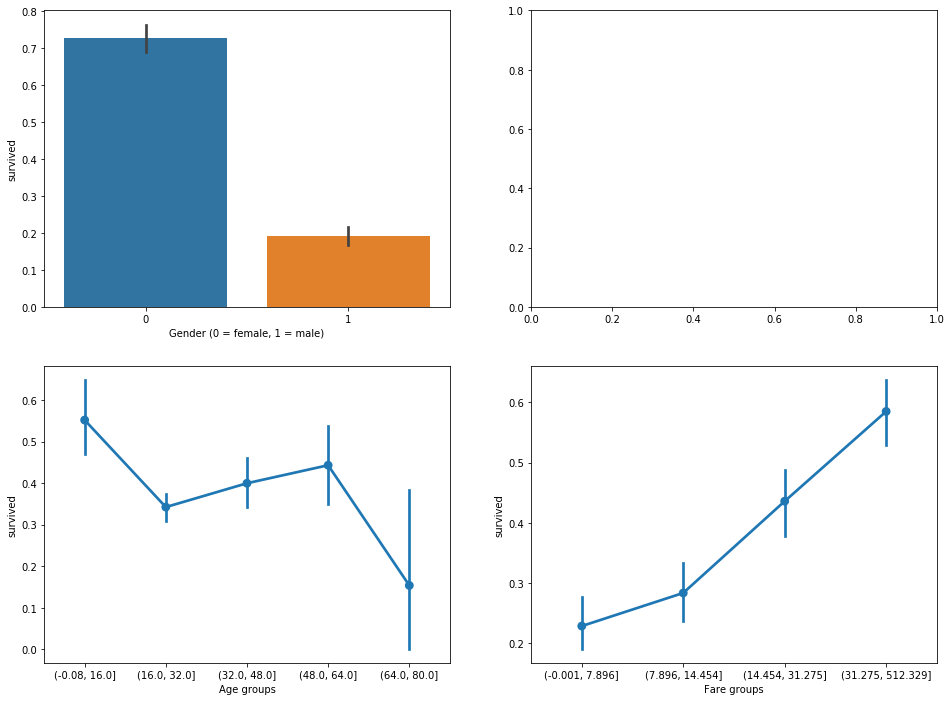

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure that will hold our plots by
# specifying the amount of rows and columns
# and its size
fig, saxis = plt.subplots(2, 2,figsize=(16,12))

# To improve the quality of our age and fare plot, we divide
# our fare and age values into x groups each.  
data['ageBin'] = pandas.cut(data['age'].astype(int), 5)
data['fareBin'] = pandas.qcut(data['fare'], 4)

sexPlot = sns.barplot(x = 'sex', y = 'survived', order=[0,1], data=data, ax = saxis[0,0])
agePlot = sns.pointplot(x = 'ageBin', y = 'survived',  data=data, ax = saxis[1,0])
farePlot = sns.pointplot(x = 'fareBin', y = 'survived',  data=data, ax = saxis[1,1])

sexPlot.set(xlabel='Gender (0 = female, 1 = male)')
agePlot.set(xlabel='Age groups')
farePlot.set(xlabel='Fare groups')


Visualising our dataset is key to understanding it better. For the sake of demonstrating the use of exploratory analysis, I decided to plot the gender, age and fare properties against the survivability property. 
It instantly becomes clear that gender plays a big role in a person's chance of survival. Age matters a bit, too, with ~55% of children between 0-16 surviving the accident, whereas only ~15% of people between 64-80 survived the accident. A last trend I noticed is: the higher the fare (ticket price paid), the higher that person's chance of survival.

Another useful exploratory measure is to determine the amount of correlation between input data (age, fare, sex, etc) and the value we are trying to classify (survived). The following method returns just that, pitting each input property against our desired 'survived' property. The number returned is known as the 'pearson correlation coefficient', and can run from -1 to 1. A negative number indicates a negative correlation, and a number greater than zero indicates a positive correlation.


In [6]:
# Return a list of dataset properties and their correlation with the
# property passed into the method (in this case the 'survived' property)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.043818
sibsp,0.027825
parch,0.082660
fare,0.244414


In this case, the sex of a passenger has a relatively high correlation coefficient towards the 'survived' property. Another important factor is the class in which the passenger was traveling (1st, 2nd, 3d class), and how much they paid for their trip (the fare).

This is extremely valuable information, because it gives us an idea which parts of our dataset will matter for solving our specific problem (survivability). To further investigate our data, we can plot some of the weakest correlations against survivability: 'parch' and 'sibsp'. 


[Text(0, 0.5, '% survived'),
 Text(0.5, 0, 'Amount of siblings/spouses (sibsp)'),
 Text(0.5, 1.0, 'Correlation between sibsp and survivability')]

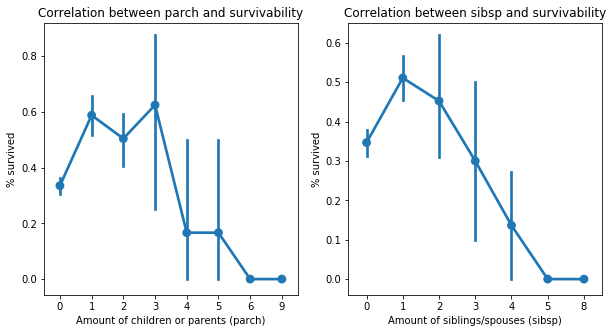

In [7]:
# Pointing out the parch sibsp problem
fig, ax =plt.subplots(1,2, figsize=(10, 5))

parchPlot = sns.pointplot(x = 'parch', y = 'survived', data=data, ax=ax[0])
sibspPlot = sns.pointplot(x = 'sibsp', y = 'survived', data=data, ax=ax[1])

parchPlot.set(xlabel='Amount of children or parents (parch)', ylabel = '% survived' , title='Correlation between parch and survivability')

sibspPlot.set(xlabel='Amount of siblings/spouses (sibsp)', ylabel = '% survived', title='Correlation between sibsp and survivability')


We can now tell that the correlation between parch or sibsp feature and the survived feature shows a very similar trend. This is worrying, because using input features that are very similar to each other can cause classification issues. We call this Multicollinearity. An oversimplified definition is that two features correlate strongly with each other (rather than the target feature - survivablity), and can cause very unpredictable results (a full explanation can be found in my paper). 

A good way to assess whether 'parch' adn 'sibsp' are indeed very similar is to plot them against each other. 

[Text(321.56363636363625, 0.5, '% survived'),
 Text(0.5, 17.200000000000003, 'Amount of siblings/spouses (sibsp)'),
 Text(0.5, 1, 'Correlation between sibsp and survivability')]

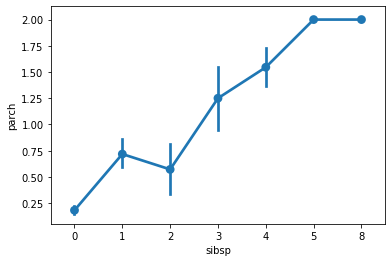

In [8]:

#fig, ax = plt.subplots(1,1, figsize=(10, 5))

sibspParchPlot = sns.pointplot(figsize = (5,5), x = 'sibsp', y = 'parch', data=data)
#relPlot = sns.barplot(x = 'relatives', y = 'survived', order=[0,1], data=data, ax = saxis[1,1])

# Set up plot information (legends, titles, labels)
# for all four plots
#relPlot.set(xlabel='Has relatives', ylabel = '% survived', title='Bar plot of new relatives feature')



sibspPlot.set(xlabel='Amount of siblings/spouses (sibsp)', ylabel = '% survived', title='Correlation between sibsp and survivability')



This plot confirms my suspicions in that the features 'sibsp' and 'parch' other, as can see a clear increasing trend between the two. In order to prevent classification problems further along the way, we have to transform these two features. This brings us to our next step: feature engineering. In feature engineering, we use domain knowledge to create new features based on existing features. 

In this case, I decided to combine the 'sibsp' and 'parch' features into a single new feature called 'relatives'. This feature is a binary value, so it can be either 0 or 1. 0 indicates that this person is alone (i.e. has no family on board), and 1 indicates that this person does have family on board. The following code creates that new feature.

In [9]:
# Create our new feature on a row-per-row basis
# by using a lambda function. If either
# sibsp or parch value for a given person is greater than zero,
# their relatives value is set to 1, else to 0. 
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)



After creating our new feature (named 'relatives'), the next step is to assess how useful it is in classifying survivability. 


In [10]:
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.043818
sibsp,0.027825
parch,0.082660
fare,0.244414
relatives,0.201719


As becomes clear from the correlation coeffecients, our new 'relatives' feature correlates with the 'survived' feature much more strongly than our previous 'parch' and 'sibsp' features. Another way to assess whether a feature is a useful addition is to visualise it. 



[Text(0, 0.5, '% survived'),
 Text(0.5, 0, 'Has relatives'),
 Text(0.5, 1.0, 'Bar plot of new relatives feature')]

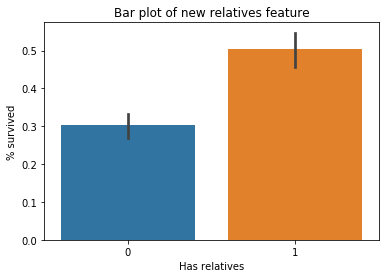

In [11]:
relPlot = sns.barplot(x = 'relatives', y = 'survived', order=[0,1], data=data)

# Set up plot information (legends, titles, labels)
# for all four plots
relPlot.set(xlabel='Has relatives', ylabel = '% survived', title='Bar plot of new relatives feature')

Our new relatives feature passes the test. It shows a clear distinction between either having or not having family on board, and can thus be used in our classification dataset instead of the parch and sibsp features. 

We are now ready to start classifying. As a last preparation step, we create a subset of our data that only contains features proven to be useful for classification, and we drop all empty values inside of them. 


With cleaning, correcting and feature engineering out of the way, we finalise our data preperation by creating a subset of our data that contains only the properties that correlate to survivability. We also drop all empty values inside this subset. 

In [12]:

# We create a subset of the data that only contains the columns specified in between the brackets.
# By doing so, we drop the properties that are too incomplete or simply not relevant (no correlation)
data = data[['sex','pclass','age','relatives','fare','survived']].dropna()
data.corr().abs()[["survived"]]

,survived
sex,0.528693
pclass,0.312469
age,0.043818
relatives,0.201719
fare,0.244414
survived,1.000000


We will now start working on a classification model. In this step, we split our dataset into a train set and a test set. Training set contains 80% of the data, test set 20%. We use the training set to train our model, and the test to verify the accuracy of the model. We also standardise our data to create a uniform scale for the numerical values (I elaborate on its importance in my paper)

In [ ]:
#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Divide the training set and test set over four variables, 
# in which x is the input data (sex, pclass, age) and y the output (survived)

# x_train: 80% of the dataset's properties, but without property 'survived' 
# y_train: the corresponding 'survived' property of the train set, used to train the model
# x_test: 20% of the dataset's properties, but without property 'survived' 
# y_test: the corresponding 'survived' property of the test set, used to determine model accuracy
x_train, x_test, y_train, y_test = train_test_split(data[['sex', 'pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)


# Create an instance of an object that standardises data
sc = StandardScaler()

# Apply standardisation to the input data (x)
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)


Now all our data is divided between test and training sets and is standardised, we can start fitting classification models. There's various classification models that can be used, as explained more elaborately in my paper. In this step, I create an empty list to which I then append different classifiers imported from libraries.

In [14]:
# There's various ML algorithms to apply, in order to help
# you choose there's a chart to help you choose here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

from sklearn.model_selection import train_test_split
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Create an empty list that will hold various classifiers
classifiers = []

# Append classifiers to list
model = GaussianNB()
classifiers.append(model)

model2 = svm.SVC()
classifiers.append(model2)

model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)

model4 = RandomForestClassifier()
classifiers.append(model4)



As becomes clear, the Random Forest Classifier has the highest accuracy at ~80%. The confusion matrix shows us the absolute amount of true positives, false positives, false negatives and true negatives.  

Now we have a list will different classification algorithms, it is time to apply them. We will loop over the list of classifiers, and fit our model with the data we prepared in the previous steps. After fitting, we output the accuracy (percentage) of each model and the corresponding confusion matrix in order to assess model accuracy.

In [15]:
# For every classifier in the list of classifiers
# we created in the previous step
for classifier in classifiers:
    # Fit the model with our cleaned data and 
    # obtain its accuracy score
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # Obtain classifier name, then output the
    # corresponding accuracy and its confusion matrix
    classifierName = type(classifier).__name__
    print("Accuracy of classification algorithm: %s is:%s"%(classifierName, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of classification algorithm: %s is: %s"%(classifierName, cm))
    print("---------------------------")

Accuracy of classification algorithm: GaussianNB is:0.7748091603053435
Confusion Matrix of classification algorithm: GaussianNB is: [[144  18]
 [ 41  59]]
---------------------------
Accuracy of classification algorithm: SVC is:0.7824427480916031
Confusion Matrix of classification algorithm: SVC is: [[153   9]
 [ 48  52]]
---------------------------
Accuracy of classification algorithm: DecisionTreeClassifier is:0.7519083969465649
Confusion Matrix of classification algorithm: DecisionTreeClassifier is: [[132  30]
 [ 35  65]]
---------------------------
Accuracy of classification algorithm: RandomForestClassifier is:0.7900763358778626
Confusion Matrix of classification algorithm: RandomForestClassifier is: [[144  18]
 [ 37  63]]
---------------------------
